# Tutorial 22: Logarithmic Mean Risk Optimization (Kelly Criterion)

## 1. Downloading the data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2000-01-01'
end = '2019-12-31'

# Tickers of assets
assets = ['AIG', 'AKAM', 'AMT', 'APA', 'BA', 'BAX', 'BKNG',
          'BMY', 'CMCSA', 'CNP', 'CPB', 'DE', 'MO', 'MSFT', 'NI',
          'NKTR', 'NTAP', 'PCAR', 'PSA', 'REGN', 'SBAC', 'SEE', 'T',
          'TGT', 'TMO', 'TTWO']

assets.sort()

# Downloading data
data = yf.download(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = assets

[*********************100%%**********************]  26 of 26 completed


In [2]:
# Calculating returns

#Y = data[assets].pct_change().dropna()
Y = data[assets].copy()
Y = Y.resample('M').last().pct_change().dropna()
print(Y.shape)
display(Y.head())

(239, 26)


,AIG,AKAM,AMT,APA,BA,BAX,BKNG,BMY,CMCSA,CNP,...,NTAP,PCAR,PSA,REGN,SBAC,SEE,T,TGT,TMO,TTWO
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-29,-15.2695%,4.8670%,37.2822%,0.0000%,-16.7100%,-14.6772%,-3.5560%,-13.5849%,-7.2464%,-8.3353%,...,88.0449%,4.6443%,-2.7548%,358.8832%,33.6083%,-11.4699%,-11.9534%,-10.2961%,-9.7473%,0.0000%
2000-03-31,23.8863%,-38.4450%,0.2538%,36.5170%,2.3689%,15.0230%,43.0168%,-0.2183%,3.1250%,14.5897%,...,-12.3179%,16.1103%,-3.8082%,-47.6770%,8.6420%,9.3082%,11.5894%,26.6949%,30.4000%,6.5327%
2000-04-30,0.1712%,-38.5154%,-5.6962%,-2.6382%,4.9587%,8.5878%,-20.9375%,-7.8650%,-5.4546%,12.9973%,...,-10.6495%,-4.8750%,6.5476%,-3.3827%,-7.6705%,2.4166%,4.7667%,-10.9532%,-4.9080%,-27.3585%
2000-05-31,2.6662%,-32.4905%,-20.2685%,25.6128%,-1.2138%,2.1113%,-39.7233%,5.0060%,-3.6859%,8.7704%,...,-12.6796%,-11.3612%,-0.2793%,-28.6652%,-8.3077%,0.6741%,-0.2854%,-5.6896%,-4.1935%,-5.8442%
2000-06-30,4.3865%,77.8792%,12.2896%,-3.3385%,7.0400%,5.7330%,-0.3688%,5.7889%,3.4942%,3.5012%,...,24.6854%,-5.2239%,6.1300%,46.3190%,39.4295%,-6.4732%,0.7153%,-7.4776%,13.4680%,33.7931%


## 2. Estimating Logarithmic Mean Variance Portfolios

### 2.1 Calculating the portfolio that maximizes Risk Adjusted Return.

In [3]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:

port.solvers = ['MOSEK']
model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w_1 = port.optimization(model=model, rm=rm, obj=obj, kelly=False, rf=rf, l=l, hist=hist)
w_2 = port.optimization(model=model, rm=rm, obj=obj, kelly='approx', rf=rf, l=l, hist=hist)
w_3 = port.optimization(model=model, rm=rm, obj=obj, kelly='exact', rf=rf, l=l, hist=hist)

w = pd.concat([w_1, w_2, w_3], axis=1)
w.columns = ['Arithmetic', 'Log Approx', 'Log Exact']

display(w)

,Arithmetic,Log Approx,Log Exact
AIG,0.0000%,0.0000%,0.0000%
AKAM,0.0000%,0.0000%,0.0000%
AMT,0.0000%,0.0001%,0.0000%
APA,0.0000%,0.0000%,0.0000%
BA,1.4589%,1.4078%,1.3887%
BAX,1.3213%,1.8790%,1.8891%
BKNG,2.6984%,2.5498%,2.5603%
BMY,0.0000%,0.0792%,0.1514%
CMCSA,0.0000%,0.0000%,0.0000%
CNP,0.0000%,0.3560%,0.4178%


<Axes: >

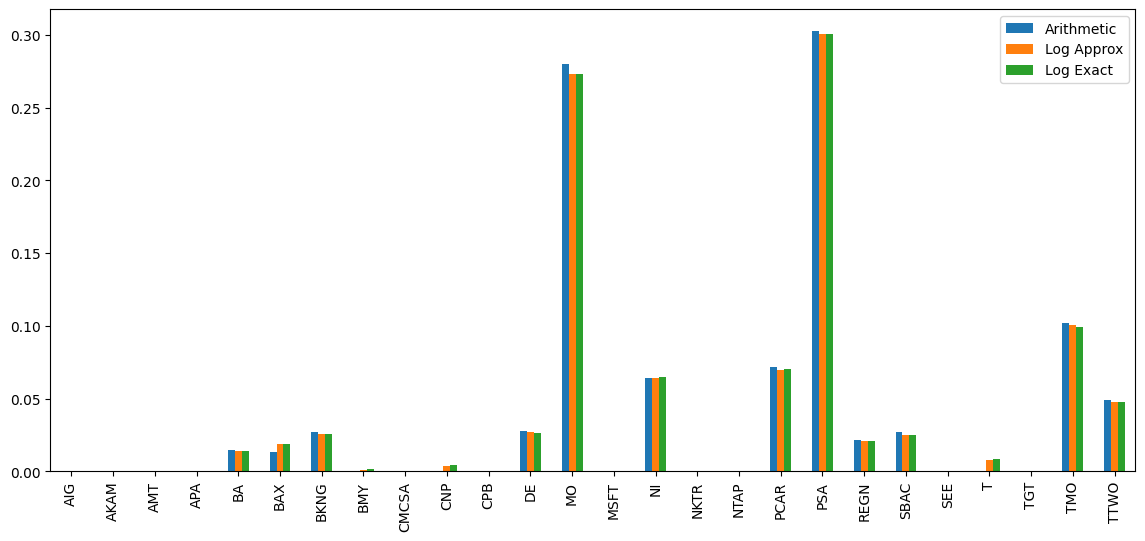

In [4]:
fig, ax = plt.subplots(figsize=(14,6))
w.plot(kind='bar', ax = ax)

In [5]:
returns = port.returns
cov = port.cov

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy()))
x = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Risk Adjusted Return:")
print("Arithmetic", (y/x).item() * 12**0.5)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy()))
x = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Approx", (y/x).item() * 12**0.5)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_3.to_numpy()))
x = rp.Sharpe_Risk(w_3, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Exact", (y/x).item() * 12**0.5)

Risk Adjusted Return:
Arithmetic 1.2708636429263729
Log Approx 1.2712778131885676
Log Exact 1.2712857067239611


이 코드는 최적화된 포트폴리오 가중치 `w_1`, `w_2`, `w_3`에 대해 위험 조정 수익률(Risk Adjusted Return)을 계산하고 출력합니다. 각 포트폴리오 가중치에 대해 로그 수익률을 계산하고, 이를 샤프 비율로 조정하여 연간화된 위험 조정 수익률을 구합니다. 아래는 코드의 상세 설명입니다.

### 변수 및 설정
1. **포트폴리오 수익률 및 공분산 행렬 가져오기**:
   ```python
   returns = port.returns
   cov = port.cov
   ```
   - `returns`: 포트폴리오의 역사적 수익률 데이터.
   - `cov`: 포트폴리오 자산의 공분산 행렬.

### 위험 조정 수익률 계산
2. **Arithmetic 포트폴리오 (w_1)**:
   - 로그 수익률 계산:
     ```python
     y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy()))
     ```
     - `returns @ w_1.to_numpy()`: 포트폴리오의 일간 수익률을 계산합니다.
     - `np.log(1 + ...)`: 로그 수익률을 계산합니다.
     - `np.sum(...)`: 모든 로그 수익률을 합산합니다.
     - `1/(returns.shape[0])`: 일간 로그 수익률의 평균을 계산합니다.

   - 샤프 리스크 계산:
     ```python
     x = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
     ```
     - `rp.Sharpe_Risk(...)`: 주어진 가중치, 공분산 행렬, 수익률 데이터를 사용하여 샤프 리스크를 계산합니다.

   - 위험 조정 수익률 출력:
     ```python
     print("Risk Adjusted Return:")
     print("Arithmetic", (y/x).item() * 12**0.5)
     ```
     - `y/x`: 로그 수익률을 샤프 리스크로 나누어 위험 조정 수익률을 계산합니다.
     - `* 12**0.5`: 월간 수익률로 변환하기 위해 연간화를 수행합니다.
     - 결과를 출력합니다.

3. **Log Approx 포트폴리오 (w_2)**:
   - 로그 수익률 계산:
     ```python
     y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy()))
     ```

   - 샤프 리스크 계산:
     ```python
     x = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
     ```

   - 위험 조정 수익률 출력:
     ```python
     print("Log Approx", (y/x).item() * 12**0.5)
     ```

4. **Log Exact 포트폴리오 (w_3)**:
   - 로그 수익률 계산:
     ```python
     y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_3.to_numpy()))
     ```

   - 샤프 리스크 계산:
     ```python
     x = rp.Sharpe_Risk(w_3, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
     ```

   - 위험 조정 수익률 출력:
     ```python
     print("Log Exact", (y/x).item() * 12**0.5)
     ```

### 전체 코드 요약
이 코드는 최적화된 세 가지 포트폴리오 (Arithmetic, Log Approx, Log Exact)에 대해 위험 조정 수익률을 계산합니다. 이를 위해 먼저 각 포트폴리오의 로그 수익률을 계산하고, 샤프 리스크를 사용하여 위험 조정 수익률을 구한 후, 이를 월간 수익률로 연간화하여 출력합니다. 이렇게 하면 각 포트폴리오의 성과를 비교할 수 있습니다.

## 캘리 기준이란?

켈리 기준(Kelly Criterion)은 도박 및 투자 분야에서 자본을 최적의 비율로 배분하여 장기적인 자산의 성장률을 극대화하는 방법론입니다. 이 기준은 주어진 자산에 대해 어떤 비율로 자본을 투자해야 하는지를 결정하기 위해 사용됩니다. 켈리 기준은 자본의 장기적인 기하평균 성장률을 최대화하는 투자 전략을 제시합니다.

### 기본 개념
켈리 기준은 다음과 같은 수학적 공식으로 표현됩니다:

$$ f^* = \frac{bp - q}{b} $$

여기서:
- $ f^* $는 투자 비율입니다 (전체 자본의 몇 퍼센트를 투자할 것인지).
- $ b $는 배당 비율 (승리할 경우 얻는 배당금의 비율).
- $ p $는 성공 확률입니다.
- $ q $는 실패 확률 ($ q = 1 - p $)입니다.

이 공식은 도박 상황에서 유래되었으며, 투자 분야에서도 유사한 방식으로 적용됩니다.

### 투자에 적용
투자에 있어 켈리 기준은 주어진 자산의 기대 수익률과 리스크를 기반으로 포트폴리오를 최적화합니다. 기대 수익률이 높고 리스크가 낮을수록 더 많은 자본을 투자하는 것이 바람직합니다.

### 켈리 기준의 장점
1. **장기적인 자산 성장 극대화**: 켈리 기준은 기하평균 수익률을 최대화하므로 장기적인 자산 성장에 유리합니다.
2. **리스크 관리**: 과도한 리스크를 피하고, 적절한 투자 비율을 유지함으로써 파산 가능성을 줄입니다.

### 켈리 기준의 단점
1. **수익률과 확률의 정확한 추정 필요**: 켈리 기준을 제대로 적용하려면 자산의 기대 수익률과 성공 확률을 정확하게 추정해야 합니다. 이는 실무에서 매우 어려운 일입니다.
2. **변동성**: 켈리 기준을 완전히 따를 경우 변동성이 커질 수 있습니다. 이로 인해 투자자가 심리적으로 불안해질 수 있습니다.

### 예시
간단한 예를 들어 켈리 기준을 설명하겠습니다. 만약 어떤 주식의 기대 수익률이 10%이고, 실패 확률이 50%라고 가정해 보겠습니다. 배당 비율이 1:1 (즉, 100% 수익 또는 100% 손실)일 때, 켈리 기준에 따른 투자 비율은 다음과 같이 계산됩니다:

$$ f^* = \frac{(1 \times 0.5) - 0.5}{1} = 0 $$

이 예시에서는, 기대 수익률과 실패 확률이 동일하므로 켈리 기준에 따르면 투자하지 않는 것이 최적입니다.

### 결론
켈리 기준은 투자 포트폴리오를 최적화하여 장기적인 자산 성장을 극대화하기 위한 강력한 방법론입니다. 그러나 이를 적용하기 위해서는 자산의 기대 수익률과 리스크를 정확하게 추정하는 것이 중요하며, 변동성을 감내할 수 있는 투자자의 심리적 준비도 필요합니다.


### 1. Arithmetic (산술적 켈리 기준)
- **설명**: 전통적인 켈리 기준으로, 기대 수익률을 기반으로 자본 배분을 결정합니다.
- **수학적 표현**:
  $$ f^* = \frac{\mu - rf}{\sigma^2} $$
  여기서 $ \mu $는 기대 수익률, $ rf $는 무위험 이자율, $ \sigma^2 $는 수익률의 분산입니다.
- **특징**: 산술적 켈리 기준은 주어진 기간 동안의 단일 기대 수익률과 리스크를 기반으로 계산됩니다.

### 2. Log Approx (로그 근사 켈리 기준)
- **설명**: 로그 수익률을 근사하여 켈리 기준을 계산하는 방법입니다.
- **수학적 표현**:
  $$ f^* = \frac{\mu - rf}{\sigma^2} - \frac{\sigma^2}{2} $$
  여기서 $ \mu $는 기대 수익률, $ rf $는 무위험 이자율, $ \sigma^2 $는 수익률의 분산입니다.
- **특징**: 로그 수익률을 근사하여 사용하기 때문에, 연속 복리를 고려한 경우에 더 적합합니다. 이는 더 현실적인 포트폴리오 최적화를 가능하게 합니다.

### 3. Log Exact (정확한 로그 켈리 기준)
- **설명**: 로그 수익률을 정확히 계산하여 켈리 기준을 적용하는 방법입니다.
- **수학적 표현**:
  $$ f^* = \frac{\mu - rf}{\sigma^2} - \frac{\sigma^2}{2(1 + rf)} $$
  여기서 $ \mu $는 기대 수익률, $ rf $는 무위험 이자율, $ \sigma^2 $는 수익률의 분산입니다.
- **특징**: 로그 수익률을 정확히 반영하므로, 특히 높은 변동성을 갖는 자산에 대해 더 정교한 자본 배분을 제공합니다.



| 방법          | 설명                                                                 | 수학적 표현                                                                                   | 특징                                                      |
|--------------|----------------------------------------------------------------------|---------------------------------------------------------------------------------------------|----------------------------------------------------------|
| Arithmetic   | 전통적인 켈리 기준, 기대 수익률을 기반으로 자본 배분 결정              | $ f^* = \frac{\mu - rf}{\sigma^2} $                                                        | 단일 기대 수익률과 리스크를 기반으로 계산                 |
| Log Approx   | 로그 수익률을 근사하여 켈리 기준 계산                                  | $ f^* = \frac{\mu - rf}{\sigma^2} - \frac{\sigma^2}{2} $                                   | 연속 복리를 고려한 경우에 더 적합, 현실적인 포트폴리오 최적화 |
| Log Exact    | 로그 수익률을 정확히 계산하여 켈리 기준 적용                            | $ f^* = \frac{\mu - rf}{\sigma^2} - \frac{\sigma^2}{2(1 + rf)} $                           | 높은 변동성을 갖는 자산에 대해 더 정교한 자본 배분 제공    |

### 2.2 Calculate efficient frontier

In [6]:
points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, kelly="exact", points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AIG,AKAM,AMT,APA,BA,BAX,BKNG,BMY,CMCSA,CNP,...,NTAP,PCAR,PSA,REGN,SBAC,SEE,T,TGT,TMO,TTWO
0,0.0000%,0.0000%,0.0000%,0.9732%,0.0000%,6.5649%,0.0000%,8.8956%,4.2389%,4.6817%,...,0.0000%,0.0047%,21.9645%,0.9348%,0.0000%,0.0000%,8.7338%,2.6977%,1.2639%,1.9032%
1,0.0000%,0.0000%,0.0000%,0.0000%,0.4697%,4.2743%,1.5116%,4.3742%,0.0000%,2.8896%,...,0.0000%,4.8771%,27.7612%,1.6011%,0.9927%,0.0000%,4.9225%,0.0297%,7.6685%,3.8109%
2,0.0000%,0.0000%,0.0000%,0.0000%,1.0669%,2.6834%,2.3190%,1.5048%,0.0000%,1.1507%,...,0.0000%,6.5123%,29.6692%,1.9032%,2.1296%,0.0000%,2.3495%,0.0000%,9.6204%,4.5798%
3,0.0000%,0.0000%,0.0000%,0.0000%,1.1690%,0.0000%,3.1125%,0.0000%,0.0000%,0.0000%,...,0.0000%,7.3735%,30.3568%,2.4822%,3.3581%,0.0000%,0.0000%,0.0000%,9.7291%,5.7722%
4,0.0000%,0.0000%,0.0000%,0.0000%,0.0269%,0.0000%,3.9908%,0.0000%,0.0000%,0.0000%,...,0.0000%,7.5013%,30.0451%,3.1738%,4.7583%,0.0000%,0.0000%,0.0000%,8.3938%,7.7205%


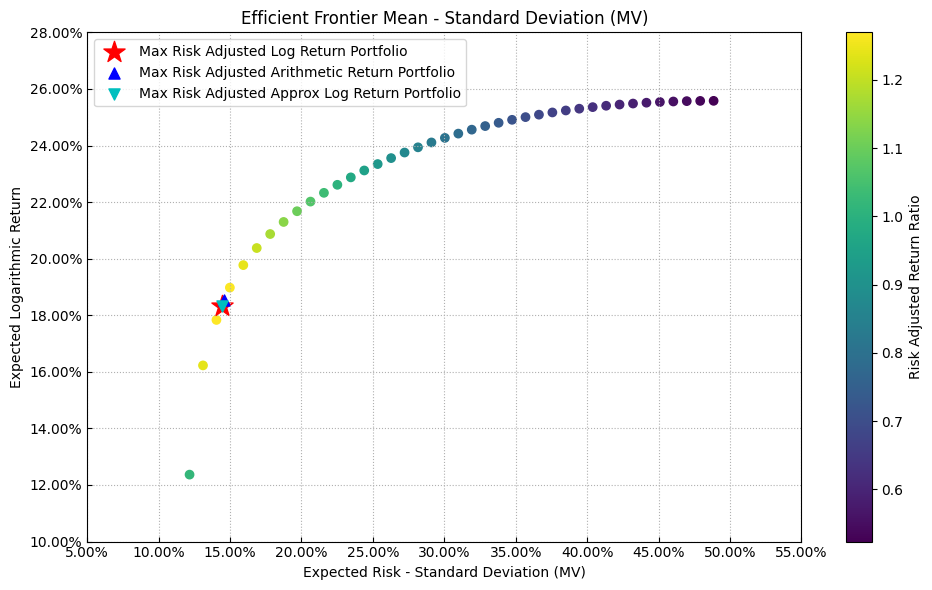

In [7]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Log Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

fig, ax = plt.subplots(figsize=(10,6))
rp.plot_frontier(w_frontier=frontier,
                 mu=mu,
                 cov=cov,
                 returns=returns,
                 rm=rm,
                 kelly=True,
                 rf=rf,
                 alpha=0.05,
                 cmap='viridis',
                 w=w_3,
                 label=label,
                 marker='*',
                 s=16,
                 c='r',
                 height=6,
                 width=10,
                 t_factor=12,
                 ax=ax)

y1 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy())) * 12 
x1 = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05) * 12**0.5

y2 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy())) * 12 
x2 = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05) * 12**0.5

ax.scatter(x=x1,
           y=y1,
           marker="^",
           s=8**2,
           c="b",
           label="Max Risk Adjusted Arithmetic Return Portfolio")
ax.scatter(x=x2,
           y=y2,
           marker="v",
           s=8**2,
           c="c",
           label="Max Risk Adjusted Approx Log Return Portfolio")
plt.legend()

## 2. Estimating Logarithmic Mean EVaR Portfolios

### 2.1 Calculating the portfolio that maximizes Risk Adjusted Return.

In [8]:
rm = 'EVaR' # Risk measure

w_1 = port.optimization(model=model, rm=rm, obj=obj, kelly=False, rf=rf, l=l, hist=hist)
w_2 = port.optimization(model=model, rm=rm, obj=obj, kelly='approx', rf=rf, l=l, hist=hist)
w_3 = port.optimization(model=model, rm=rm, obj=obj, kelly='exact', rf=rf, l=l, hist=hist)

w = pd.concat([w_1, w_2, w_3], axis=1)
w.columns = ['Arithmetic', 'Log Approx', 'Log Exact']

display(w)

,Arithmetic,Log Approx,Log Exact
AIG,0.0000%,0.0000%,0.0000%
AKAM,0.0000%,0.0000%,0.0000%
AMT,0.0000%,0.0000%,0.0000%
APA,6.6632%,3.0783%,3.4320%
BA,0.0000%,0.0000%,0.0000%
BAX,6.0536%,2.2680%,2.3696%
BKNG,6.9014%,5.0119%,5.1706%
BMY,4.7030%,6.7805%,6.8637%
CMCSA,0.0000%,0.0000%,0.0000%
CNP,0.0844%,2.9060%,2.7660%


<Axes: >

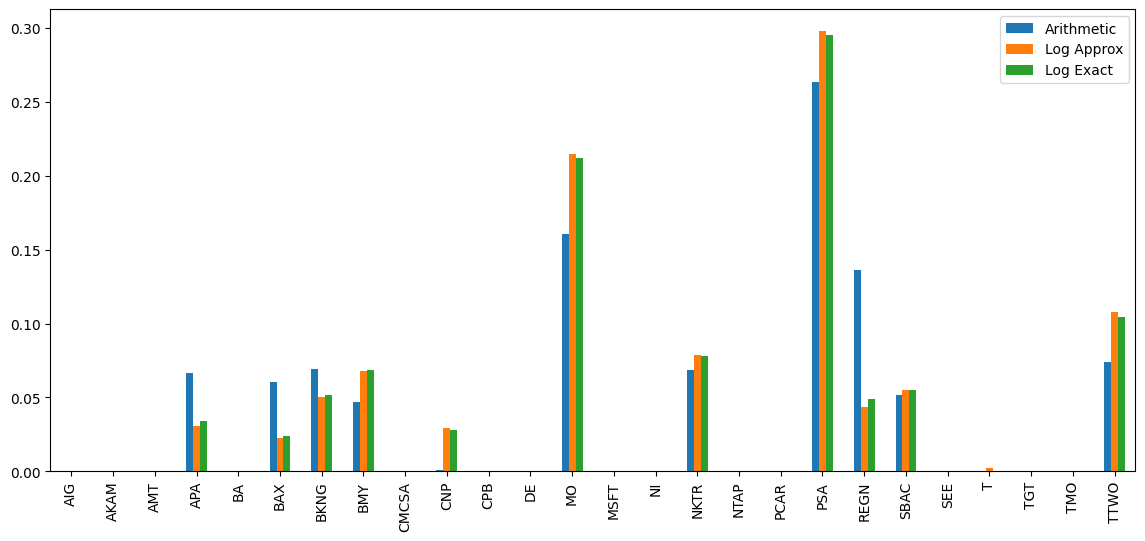

In [9]:
fig, ax = plt.subplots(figsize=(14,6))
w.plot(kind='bar', ax = ax)

In [10]:
returns = port.returns
cov = port.cov

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy()))
x = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Risk Adjusted Return:")
print("Arithmetic", (y/x).item() * 12**0.5)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy()))
x = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Approx", (y/x).item() * 12**0.5)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_3.to_numpy()))
x = rp.Sharpe_Risk(w_3, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Exact", (y/x).item() * 12**0.5)

Risk Adjusted Return:
Arithmetic 0.6328895514562026
Log Approx 0.6462646687708027
Log Exact 0.646339181294533


### 3.2 Calculate efficient frontier

In [11]:
points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, kelly="exact", points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AIG,AKAM,AMT,APA,BA,BAX,BKNG,BMY,CMCSA,CNP,...,NTAP,PCAR,PSA,REGN,SBAC,SEE,T,TGT,TMO,TTWO
0,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,2.8287%,2.3020%,18.2686%,0.0000%,1.9355%,...,0.0000%,0.0000%,17.2219%,0.0000%,5.2723%,0.0000%,6.7947%,0.0000%,7.5239%,8.0870%
1,0.0000%,0.0000%,0.0000%,3.4481%,0.0000%,3.8678%,3.1556%,11.5998%,0.0000%,3.8139%,...,0.0000%,0.0000%,25.2996%,0.0000%,7.1301%,0.0000%,4.4124%,0.0000%,0.0000%,11.6059%
2,0.0000%,0.0000%,0.0000%,4.2820%,0.0000%,2.8145%,3.7346%,10.1902%,0.0000%,3.6608%,...,0.0000%,0.0000%,27.5500%,1.1712%,6.6494%,0.0000%,1.7243%,0.0000%,0.0000%,11.3771%
3,0.0000%,0.0000%,0.0000%,3.9387%,0.0000%,2.7740%,4.6238%,7.9821%,0.0000%,3.0594%,...,0.0000%,0.0000%,28.6373%,3.6376%,5.8159%,0.0000%,0.7739%,0.0000%,0.0000%,10.7413%
4,0.0000%,0.0000%,0.0000%,3.0465%,0.0000%,2.2116%,5.3236%,6.0729%,0.0000%,2.5930%,...,0.0000%,0.0000%,29.9370%,5.5014%,5.3979%,0.0000%,0.0000%,0.0000%,0.0000%,10.4702%


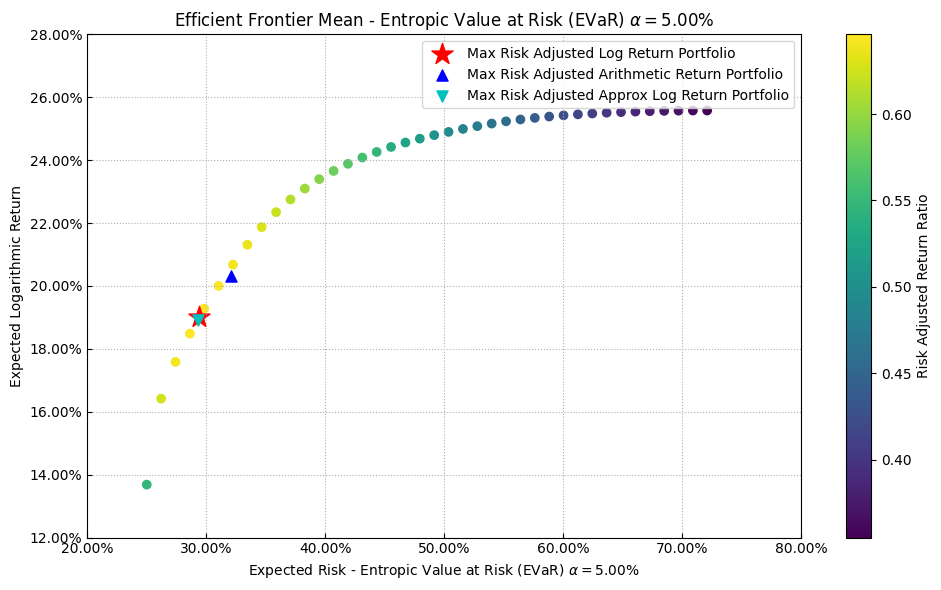

In [12]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Log Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

fig, ax = plt.subplots(figsize=(10,6))
rp.plot_frontier(w_frontier=frontier,
                 mu=mu,
                 cov=cov,
                 returns=returns,
                 rm=rm,
                 kelly=True,
                 rf=rf,
                 alpha=0.05,
                 cmap='viridis',
                 w=w_3,
                 label=label,
                 marker='*',
                 s=16,
                 c='r',
                 height=6,
                 width=10,
                 t_factor=12,
                 ax=ax)

y1 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy())) * 12
x1 = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05) * 12**0.5

y2 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy())) * 12
x2 = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05) * 12**0.5

ax.scatter(x=x1,
           y=y1,
           marker="^",
           s=8**2,
           c="b",
           label="Max Risk Adjusted Arithmetic Return Portfolio")
ax.scatter(x=x2,
           y=y2,
           marker="v",
           s=8**2,
           c="c",
           label="Max Risk Adjusted Approx Log Return Portfolio")
plt.legend()

## 3. Estimating Logarithmic Mean EDaR Portfolios

### 3.1 Calculating the portfolio that maximizes Risk Adjusted Return.

In [13]:
rm = 'EDaR' # Risk measure

w_1 = port.optimization(model=model, rm=rm, obj=obj, kelly=False, rf=rf, l=l, hist=hist)
w_2 = port.optimization(model=model, rm=rm, obj=obj, kelly='approx', rf=rf, l=l, hist=hist)
w_3 = port.optimization(model=model, rm=rm, obj=obj, kelly='exact', rf=rf, l=l, hist=hist)

w = pd.concat([w_1, w_2, w_3], axis=1)
w.columns = ['Arithmetic', 'Log Approx', 'Log Exact']

display(w)

,Arithmetic,Log Approx,Log Exact
AIG,0.0000%,0.0000%,0.0000%
AKAM,0.0000%,0.0000%,0.0000%
AMT,2.8669%,0.3719%,0.5224%
APA,0.0000%,0.0000%,0.0000%
BA,0.0000%,0.0000%,0.0000%
BAX,0.0000%,0.0000%,0.0000%
BKNG,3.0492%,1.4560%,1.6956%
BMY,0.0000%,0.0000%,0.0000%
CMCSA,0.0000%,0.0000%,0.0000%
CNP,0.0000%,0.0000%,0.0000%


<Axes: >

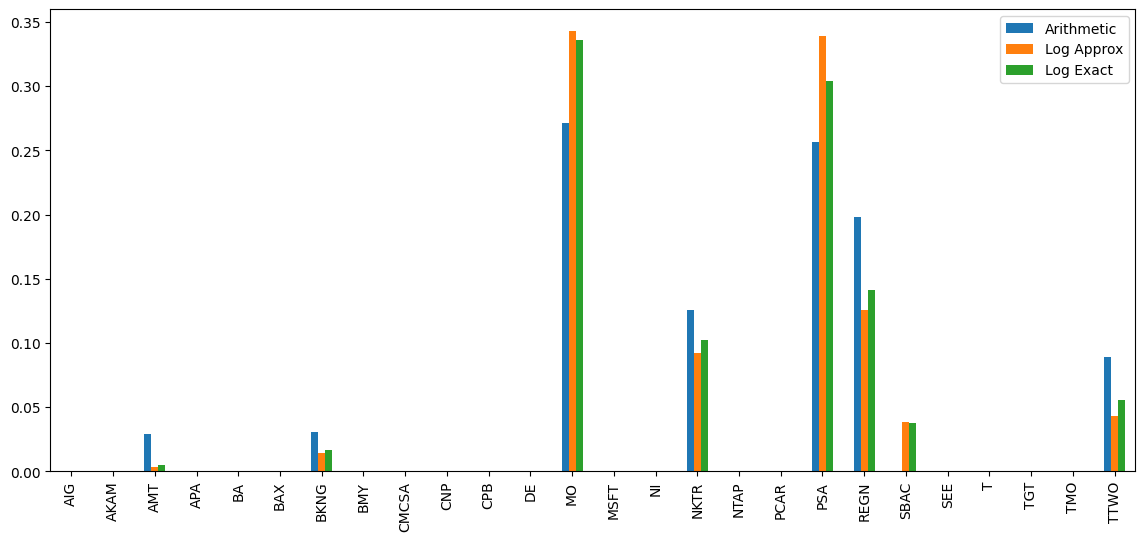

In [14]:
fig, ax = plt.subplots(figsize=(14,6))
w.plot(kind='bar', ax = ax)

In [15]:
returns = port.returns
cov = port.cov

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy()))
x = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Risk Adjusted Return:")
print("Arithmetic", (y/x).item() * 12)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy()))
x = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Approx", (y/x).item() * 12)

y = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_3.to_numpy()))
x = rp.Sharpe_Risk(w_3, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)
print("Log Exact", (y/x).item() * 12)

Risk Adjusted Return:
Arithmetic 0.8286213483644566
Log Approx 0.8435844052786354
Log Exact 0.8449870500760592


### 3.2 Calculate efficient frontier

In [16]:
points = 40 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, kelly="exact", points=points, rf=rf, hist=hist)

display(frontier.T.head())

,AIG,AKAM,AMT,APA,BA,BAX,BKNG,BMY,CMCSA,CNP,...,NTAP,PCAR,PSA,REGN,SBAC,SEE,T,TGT,TMO,TTWO
0,0.0000%,0.0000%,1.9630%,5.5772%,0.0000%,0.0000%,1.9599%,2.3310%,0.0000%,0.0000%,...,0.0000%,0.0000%,23.2473%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
1,0.0000%,0.0000%,2.5704%,3.6696%,0.0000%,0.0000%,0.9192%,0.0000%,0.0000%,0.0000%,...,0.0000%,0.0000%,31.4908%,5.8685%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0000%
2,0.0000%,0.0000%,3.2750%,1.2159%,0.0000%,0.0000%,0.3203%,0.0000%,0.0000%,0.0000%,...,0.0000%,0.0000%,36.5055%,8.0957%,0.4379%,0.0000%,0.0000%,0.0000%,0.0000%,0.7604%
3,0.0000%,0.0000%,1.6926%,0.0000%,0.0000%,0.0000%,1.2423%,0.0000%,0.0000%,0.0000%,...,0.0000%,0.0000%,34.9683%,12.1345%,2.4519%,0.0000%,0.0000%,0.0000%,0.0000%,3.5030%
4,0.0000%,0.0000%,0.8849%,0.0000%,0.0000%,0.0000%,1.8560%,0.0000%,0.0000%,0.0000%,...,0.0000%,0.0000%,27.4039%,15.3671%,3.4524%,0.0000%,0.0000%,0.0000%,0.0000%,6.5587%


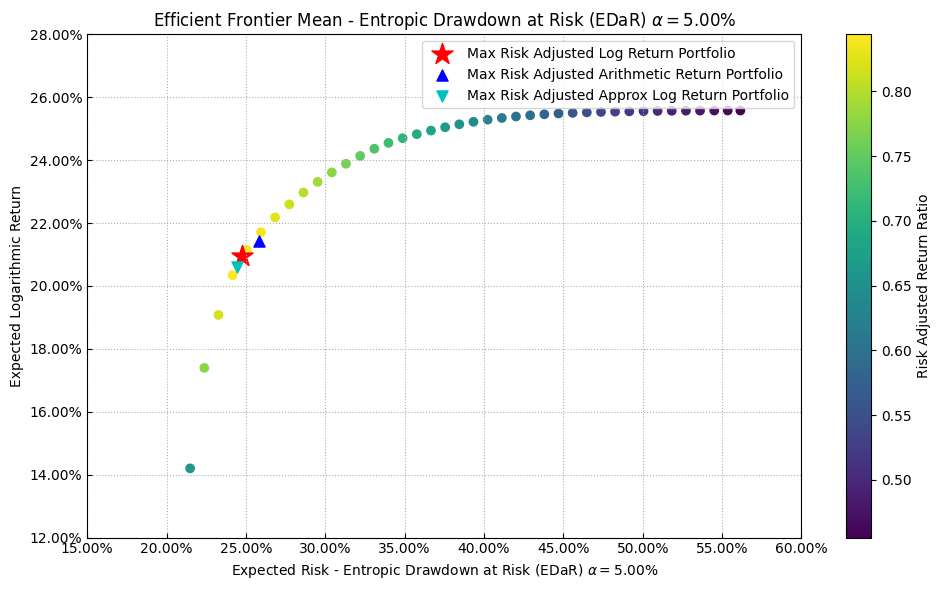

In [17]:
# Plotting the efficient frontier

label = 'Max Risk Adjusted Log Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

fig, ax = plt.subplots(figsize=(10,6))
rp.plot_frontier(w_frontier=frontier,
                 mu=mu,
                 cov=cov,
                 returns=returns,
                 rm=rm,
                 kelly=True,
                 rf=rf,
                 alpha=0.05,
                 cmap='viridis',
                 w=w_3,
                 label=label,
                 marker='*',
                 s=16,
                 c='r',
                 height=6,
                 width=10,
                 t_factor=12,
                 ax=ax)

y1 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_1.to_numpy())) * 12
x1 = rp.Sharpe_Risk(w_1, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)

y2 = 1/(returns.shape[0]) * np.sum(np.log(1 + returns @ w_2.to_numpy())) * 12
x2 = rp.Sharpe_Risk(w_2, cov=cov, returns=returns, rm=rm, rf=rf, alpha=0.05)

ax.scatter(x=x1,
           y=y1,
           marker="^",
           s=8**2,
           c="b",
           label="Max Risk Adjusted Arithmetic Return Portfolio")
ax.scatter(x=x2,
           y=y2,
           marker="v",
           s=8**2,
           c="c",
           label="Max Risk Adjusted Approx Log Return Portfolio")
plt.legend()